# Cross validation experiments of faster R-CNN with ResNet50 backbone

In [1]:
# Basic python and ML Libraries
import os
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')
# We will be reading images using OpenCV
import cv2
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import glob
import time

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
google_static_images = True
if google_static_images:
    train_dir_imgs='/user/crossval/delhi_sarath_grid_aa_v1/3/train/images'
    train_annotation_dir = '/user/crossval/delhi_sarath_grid_aa_v1/3/train/labels'
    test_dir_imgs = '/user/crossval/delhi_sarath_grid_aa_v1/3/test/images'
    test_annotation_dir = '/user/crossval/delhi_sarath_grid_aa_v1/3/test/labels'
    
else:
    train_dir_imgs = '/user/sentinel_data/crossval/wb_grid_400_aa_v1/3/train/images'
    test_dir_imgs = '/user/sentinel_data/crossval/wb_grid_400_aa_v1/3/test/images'
    train_annotation_dir = '/user/sentinel_data/crossval/wb_grid_400_aa_v1/3/train/labels'
    test_annotation_dir = '/user/sentinel_data/crossval/wb_grid_400_aa_v1/3/test/labels'

class KilnsImageDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir,annotations_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.annotations_dir = annotations_dir
        self.height = height
        self.width = width
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        
        # classes: 0 index is reserved for background
        self.classes = ['Background', 'FCBK', 'Zigzag']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.annotations_dir, annot_filename)
        
        boxes = []
        labels = []

        f = open(annot_file_path)
        for line in f.readlines():
            class_name, xcenter, ycenter, box_width, box_height = map(float,line.split(' '))
            if int(class_name) == 0:
                class_name = 'FCBK'
            else:
                class_name = 'Zigzag'

            # finding top left and bottom right coordinates
            actual_w = box_width * 1120
            actual_h = box_height * 1120
            actual_x_c = xcenter * 1120
            actual_y_c = ycenter * 1120
            xmin , ymin =  actual_x_c - (actual_w/2), actual_y_c - (actual_h/2)
            xmax, ymax = actual_x_c + (actual_w/2), actual_y_c + (actual_h/2)
            labels.append(self.classes.index(class_name))
            boxes.append([xmin, ymin, xmax, ymax])

                

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        image_id = idx
        target["image_id"] = torch.as_tensor(image_id, dtype = torch.int64)


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target, img_name

    def __len__(self):
        return len(self.imgs)


dataset = KilnsImageDataset(train_dir_imgs, train_annotation_dir, 1120, 1120)
print('length of dataset = ', len(dataset), '\n')
img, target, img_name = dataset[0]
print(img.shape, '\n',target)


length of dataset =  285 

(1120, 1120, 3) 
 {'boxes': tensor([[515., 144., 611., 196.]]), 'labels': tensor([2]), 'area': tensor([4992.]), 'image_id': tensor(0)}


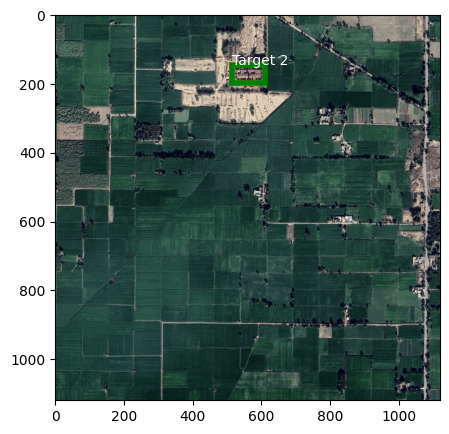

In [6]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target, pred = []):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(figsize = (5,5))
    a.imshow(img)
    for box, label in zip((target['boxes'].cpu()),target['labels'].cpu()):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 4,
                                 edgecolor = 'g',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        rx,ry = rect.get_xy()
        a.annotate(f'Target {label}', (rx,ry), color = 'white')
        
    if len(pred):
        for box, label in zip(pred['boxes'].cpu(), pred['labels'].cpu()):
            x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = patches.Rectangle((x, y),
                                    width, height,
                                    linewidth = 2,
                                    edgecolor = 'r',
                                    facecolor = 'none')

            # Draw the bounding box on top of the image
            a.add_patch(rect)
            rx, ry =rect.get_xy()
            a.annotate(f'Predicted {label}', (rx, ry + width), color = 'white')
    plt.show()
    
# plotting the image with bboxes.
img, target, img_name = dataset[0]
plot_img_bbox(img, target)



In [7]:
def get_object_detection_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [8]:
# bbox_params to set the format of bounding boxes
def get_transform():
    return A.Compose([
                        ToTensorV2(p=1.0)
                    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
dataset = KilnsImageDataset(train_dir_imgs, train_annotation_dir, 1120, 1120, transforms= get_transform())

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, 
    num_workers=1,
    collate_fn= collate_fn)

print('Length of dataset:',len(dataset))

Length of dataset: 285


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3
model = get_object_detection_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


### Train

In [12]:
# training for 100 epochs
num_epochs = 100
train_loss = []

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    # i = 0
    for imgs, annotations, img_name in data_loader:
        # i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        # sum of all losses classifier + regressor loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    train_loss.append(epoch_loss)
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

epoch : 1, Loss : 11.827605247497559, time : 32.968395709991455
epoch : 2, Loss : 8.082213401794434, time : 20.12035894393921
epoch : 3, Loss : 6.2543110847473145, time : 28.331576108932495
epoch : 4, Loss : 5.31191873550415, time : 20.21275520324707
epoch : 5, Loss : 4.718074321746826, time : 16.855711221694946
epoch : 6, Loss : 4.509758949279785, time : 16.082236289978027
epoch : 7, Loss : 3.9068264961242676, time : 15.303505182266235
epoch : 8, Loss : 3.2857933044433594, time : 16.607636213302612
epoch : 9, Loss : 3.0079779624938965, time : 17.356330156326294
epoch : 10, Loss : 2.6155765056610107, time : 19.91869068145752
epoch : 11, Loss : 2.4447946548461914, time : 25.46834444999695
epoch : 12, Loss : 2.412843704223633, time : 14.945873260498047
epoch : 13, Loss : 2.1881344318389893, time : 18.19358229637146
epoch : 14, Loss : 2.0317869186401367, time : 27.007197380065918
epoch : 15, Loss : 1.6849676370620728, time : 22.47274374961853
epoch : 16, Loss : 1.5989731550216675, time : 

[tensor(11.8276, device='cuda:0', grad_fn=<AddBackward0>), tensor(8.0822, device='cuda:0', grad_fn=<AddBackward0>), tensor(6.2543, device='cuda:0', grad_fn=<AddBackward0>), tensor(5.3119, device='cuda:0', grad_fn=<AddBackward0>), tensor(4.7181, device='cuda:0', grad_fn=<AddBackward0>), tensor(4.5098, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.9068, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.2858, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.0080, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.6156, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4448, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4128, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1881, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.0318, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.6850, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.5990, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.7418, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.5469, device='cuda:0

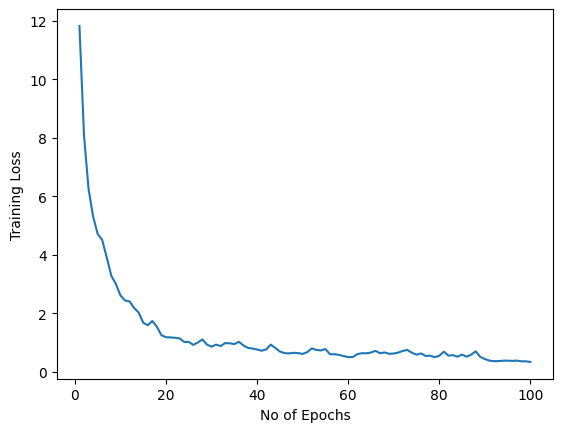

In [13]:
# Training loss curve
print(train_loss)
print(type(train_loss))
fig, ax = plt.subplots()
with torch.no_grad(): 
    train_loss1 = [loss1.to(torch.device('cpu')) for loss1 in train_loss]
    print(train_loss1)
    ax.plot(range(1,num_epochs+1),train_loss1)
    ax.set_xlabel('No of Epochs')
    ax.set_ylabel('Training Loss')

In [14]:
if google_static_images:
    torch.save(model.state_dict(),f'model_{num_epochs}_GSM_3_Delhi_v1.pt')
else:
    torch.save(model.state_dict(),f'model_{num_epochs}_Sentinel_3_WB_v1.pt')

In [15]:
num_epochs = 100
if google_static_images:
    model.load_state_dict(torch.load(f'model_{num_epochs}_GSM_3_Delhi_v1.pt'))
else:
    model.load_state_dict(torch.load(f'model_{num_epochs}_Sentinel_3_WB_v1.pt')) 

In [16]:
google_static_images

True

In [17]:
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [22]:
def make_prediction(model, img, score_threshold = 0):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > score_threshold : 
                idx_list.append(idx)
        # print(preds[id]['scores'],idx_list)
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

### Test

In [29]:
dataset_test = KilnsImageDataset(test_dir_imgs,test_annotation_dir, 1120, 1120, transforms= get_transform())
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=True, 
    num_workers=4,
    collate_fn= collate_fn)


labels_test = []
preds_adj_all_test = []
annot_all_test = []
img_names_list = []
for im, annot, img_name in data_loader_test:
    im = list(img.to(device) for img in im)
    img_names_list += [name for name in img_name]
    for t in annot:
        labels_test += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, score_threshold= 0.001)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all_test.append(preds_adj)
        annot_all_test.append(annot)

In [31]:
# saving test set predictions to yolo format in a directory
from FasterRCNN_output_to_yolo_format import save_predictions
save_predictions('crossval/high_res_v1_Delhi/3', preds_adj_all_test,img_names_list,img_width=1120, img_height=1120)

In [40]:
with torch.no_grad():
    for imgs, annotations, img_names in data_loader_test:
        img = [im.to(device) for im in imgs]
        pred = make_prediction(model, img, score_threshold= 0.001)
        break
    for i in range(len(img)):
        id = i
        img, target = imgs[id], annotations[id]
        print(f'Target: {target}')
        print(f'Prediction : {pred[id]}')
        plot_img_bbox(torch_to_pil(img), target, pred[id])

